In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from xgboost import XGBClassifier
from wordcloud import WordCloud
import pickle
import re


In [4]:
from google.colab import files
uploaded=files.upload()


Saving amazon_alexa.tsv to amazon_alexa.tsv


In [5]:
data=pd.read_csv("amazon_alexa.tsv",delimiter='\t',quoting=3)
print(f"shape of data: {data.shape}")
data.head()

shape of data: (3150, 5)


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [6]:
print(f"Columns are: {data.columns.values}")

Columns are: ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [7]:
data.isna().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [8]:
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [9]:
data.dropna(inplace=True)

In [10]:
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback


In [11]:
data['length']=data['verified_reviews'].apply(len)

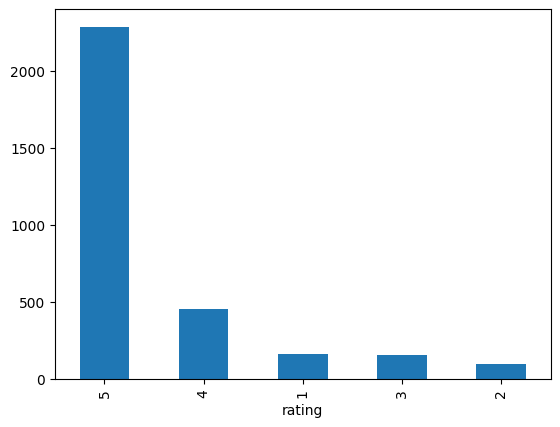

In [12]:
data['rating'].value_counts().plot.bar()
plt.show()

feedback
1    2893
0     256
Name: count, dtype: int64


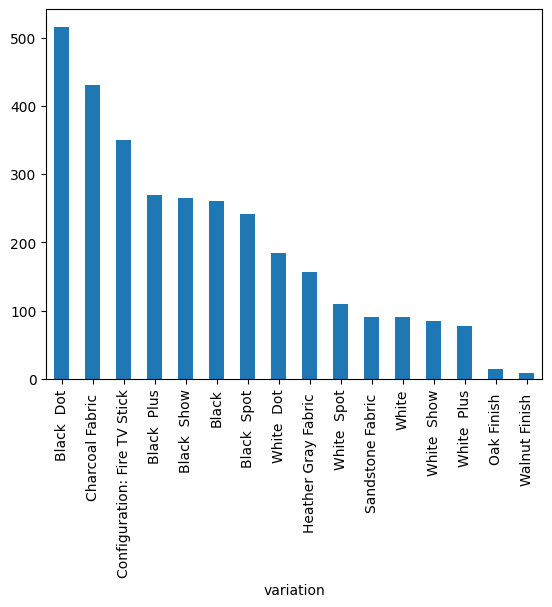

In [13]:
print(data['feedback'].value_counts())
data['variation'].value_counts().plot.bar()
plt.show()

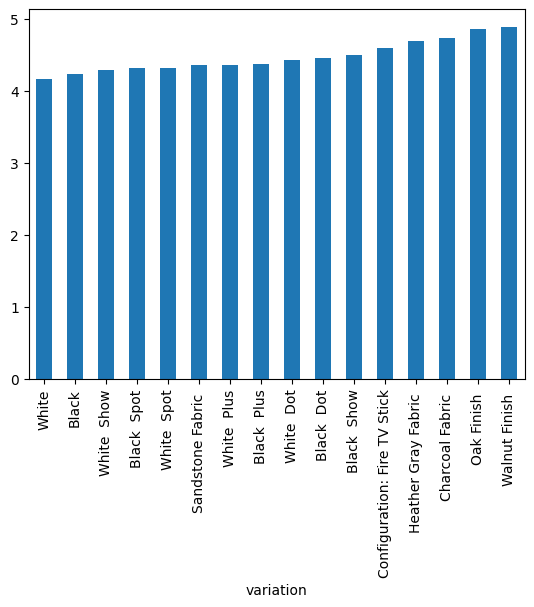

In [14]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar()
plt.show()

<Axes: xlabel='length', ylabel='Count'>

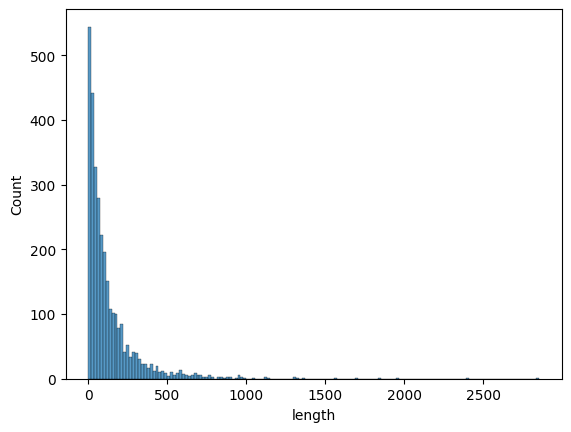

In [15]:
sns.histplot(data['length'])

<Axes: xlabel='length', ylabel='Count'>

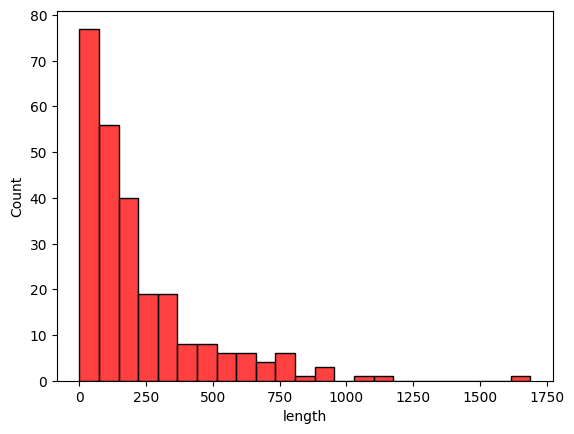

In [16]:
sns.histplot(data[data['feedback']==0]['length'],color='red')

<Axes: xlabel='length', ylabel='Count'>

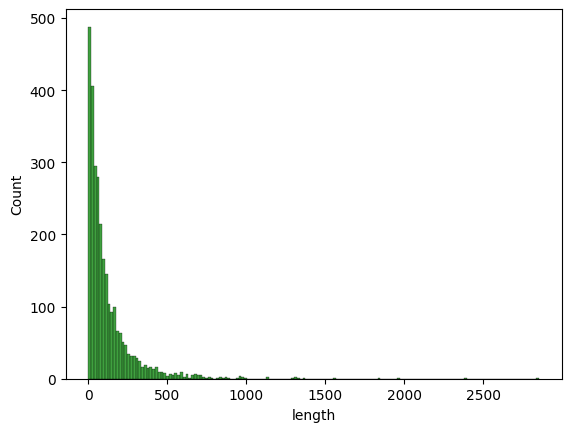

In [17]:
sns.histplot(data[data['feedback'] == 1]['length'], color='green')



In [18]:
reviews = " ".join([review for review in data['verified_reviews']])
WordCloud().generate(reviews)


In [21]:
corpus = []
stemmer = PorterStemmer()

for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  corpus.append(" ".join(review))


In [22]:
import os

# Make directory if it doesn't exist
os.makedirs('Models', exist_ok=True)


In [23]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import os

cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

# ✅ Make sure the directory exists
os.makedirs('Models', exist_ok=True)

# ✅ Save vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)


In [25]:
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))


In [26]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)


RandomForestClassifier()

In [27]:
from sklearn.metrics import accuracy_score
y_pred = model_rf.predict(X_test_scl)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9439153439153439


In [31]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)



In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Make predictions on test data
y_pred_xgb = model_xgb.predict(X_test_scl)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
pickle.dump(model_xgb, open("Models/xgboost_model.pkl", "wb"))


Accuracy: 0.9417989417989417

Confusion Matrix:
 [[ 30  48]
 [  7 860]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.38      0.52        78
           1       0.95      0.99      0.97       867

    accuracy                           0.94       945
   macro avg       0.88      0.69      0.75       945
weighted avg       0.94      0.94      0.93       945



In [33]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)
pickle.dump(model_dt, open("Models/dt_model.pkl", "wb"))
